In [3]:
import os
import numpy as np
import pandas as pd
import scipy
import ta as ta
import yfinance as yf
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LSTM, Dense, Dropout, RepeatVector,Flatten,TimeDistributed,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,Conv2D,MaxPooling2D
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from ta import add_all_ta_features
from ta.utils import dropna
from tsmoothie.smoother import *
from tsmoothie.utils_func import sim_randomwalk

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from datetime import date, timedelta
from pickle import dump,load



def CriaDiretorios(raiz_path,ativo,tipo_treinamento):
    
    Modelos_CNN = "RedesNeurais_CNN/"
    
    if os.path.exists(Modelos_CNN)==False:
        os.mkdir(Modelos_CNN)
        
    raiz_path = Modelos_CNN + raiz_path
    
    if os.path.exists(raiz_path)==False:
        os.mkdir(raiz_path)

    Raiz_ativo = raiz_path+"/"+ativo
    
    if os.path.exists(Raiz_ativo)==False:
        os.mkdir(Raiz_ativo)

    '''
    Tipo_treinamento_path = Raiz_ativo+"/"+tipo_treinamento

    if os.path.exists(Tipo_treinamento_path)==False:
        os.mkdir(Tipo_treinamento_path)
    '''

    return Raiz_ativo+"/"


def preparar_dados_financeiros(ticker,pulo,start="",end="",remove_out=False):

    print(ticker)
    
    if start == "" or end=="":
        base = yf.download(ticker)
        
    elif start !="" and end != "":
        base = yf.download(ticker,start=start,end=end)
        
        
    if base["Open"].tail(1)[0] == 0:
        base = base[:len(base)-1]

    if pulo != 0 and pulo != 1:
        
        base = ReduzirRuido(base,pulo)

    if remove_out:
        return remover_outliers(base)
    else:
        return base
    
    
def preparar_dados_financeiros_porAnos(ticker,pulo,anos_anteriores=4,remove_out=False):

    print(ticker)
    data_atual = date.today()
    data_inicial = (data_atual - timedelta(days=anos_anteriores * 365)).strftime("%Y-%m-%d")
    
    base = yf.download(ticker,start=data_inicial,end=data_atual.strftime("%Y-%m-%d"))
        
    if base["Open"].tail(1)[0] == 0:
        base = base[:len(base)-1]

    if pulo != 0 and pulo != 1:
        
        base = ReduzirRuido(base,pulo)

    if remove_out:
        return remover_outliers(base)
    else:
        return base


def remover_outliers(base):

    z_scores = scipy.stats.zscore(base)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    new_base = base[filtered_entries]

    return new_base


def ReduzirRuido(base,pulo=5):
    
    de = 0
    ate = pulo
    
    df = base.tail(len(base)-(len(base)%pulo))

    df = df.reset_index()

    lista_diario = list()
    
    for i in range(int(len(df)/pulo)):

        lista_diario.append(df[de:ate])

        de += pulo
        ate += pulo
    
    
    abertura = list()
    fechamento = list()
    maximo = list()
    minimo = list()
    datas = list()

    i = 0
    for triario in lista_diario:

        datas.append(triario["Date"][i])
        abertura.append(triario["Open"][i])
        fechamento.append(triario["Close"][i+(pulo-1)])
        maximo.append(triario["High"].max())
        minimo.append(triario["Low"].min())

        i+=pulo
        
        
    triario = zip(datas,abertura,fechamento,minimo,maximo)
    
    triario_df = pd.DataFrame(triario,columns=["Date","Open","Close","Low","High"])
    
    triario_df = triario_df.set_index("Date")

    return triario_df


def GetTsi(base, gaussian_knots, gaussian_sigma):

    tsi_config = [25, 13]

    resultados_tsi = ta.momentum.TSIIndicator(
        base["Close"], tsi_config[0], tsi_config[1], False)

    tsi_df = pd.DataFrame(resultados_tsi.tsi())

    tsi_df.dropna(inplace=True)
    
    tsi_np = tsi_df["tsi"].to_numpy()
    tsi_np.reshape(1, len(tsi_np))

    smoother = GaussianSmoother(n_knots=gaussian_knots, sigma=gaussian_sigma)
    smoother.smooth(tsi_np)

    tsi_df["gaussian"] = smoother.smooth_data[0]
    
    return tsi_df


def preparar_dados_para_treinamento(anteriores, base_treinamento_normalizada):

    previsores = []
    preco_real = []

    for i in range(anteriores, len(base_treinamento_normalizada)):

        previsores.append(base_treinamento_normalizada[i-anteriores:i, 0])
        preco_real.append(base_treinamento_normalizada[i, 0])

    previsores, preco_real = np.array(previsores), np.array(preco_real)
    previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

    return previsores, preco_real


def Normalizar(base, coluna):

    normalizador = MinMaxScaler(feature_range=(0, 1))

    if coluna == "tsi":
        Oscilador_treinamento = Oscbaseilador.iloc[:, 0:1].values

    if coluna == "gaussian":
        Oscilador_treinamento = base.iloc[:, 1:2].values


    Oscilador_normalizado = normalizador.fit_transform(Oscilador_treinamento)

    return Oscilador_normalizado, normalizador


def Realizar_previsoes(quantidade_de_previsoes,base,modelo,normalizador,coluna):
    
    #Verifica automaticamente quantos dias anteriores o modelo utiliza
    config = modelo.get_config()
    configuracao = config["layers"][0]["config"]["batch_input_shape"]
    
    anteriores=configuracao[1]
    #--------------------------------------------------------------
    
    #Pega os ultimos n registros da base
    
    if coluna == "ewm":
        entradas = base["ewm"].tail(anteriores).values
        
    if coluna == "gaussian":
        
        entradas = base["gaussian"].tail(anteriores).values
        
    entradas_ = entradas.reshape(-1,1)
    entradas_ = normalizador.transform(entradas_)

    i=0
    while i < quantidade_de_previsoes:

        X_teste = []

        X_teste.append(entradas_[-anteriores:])

        X_teste = np.array(X_teste)
        X_teste = np.reshape(X_teste,(X_teste.shape[0],X_teste.shape[1],1))

        previsao = modelo.predict(X_teste)
        previsao = normalizador.inverse_transform(previsao)    

        entradas = np.append(entradas,previsao)

        entradas_ = entradas.reshape(-1,1)

        entradas_ = normalizador.transform(entradas_)

        i+=1

    return entradas[-quantidade_de_previsoes:]


def Carregar_modelo(modelo):
    
    modelo = keras.models.load_model(modelo,compile=False)
    modelo.compile()
    return modelo

def Carregar_escalonador(scaler):
    scaler = load(open(scaler, 'rb'))
    return scaler


def Get_modelos(ticker,tipo_treinamento):
    
    Modelos_CNN = "RedesNeurais_CNN/"
    Modelos = Modelos_CNN + "Modelos"
    Ticker_Modelos = Modelos+"/"+ticker
    modelos = []
    
    if os.path.exists(Ticker_Modelos):

        for model in os.listdir(Ticker_Modelos):

            if model.endswith(".h5"):
                
                if tipo_treinamento in model:
                    
                    modelos.append(Carregar_modelo(Ticker_Modelos+"/"+model))
                    
        return modelos

    else:
        print("Nao existem modelos para esse ativo")
        return []

    
def Get_Scaler(ticker,tipo_treinamento):
    
    Modelos_CNN = "RedesNeurais_CNN/"
    Scallers  = Modelos_CNN + "Scaller"
    Ticker_Scaller = Scallers+"/"+ticker
    
    if os.path.exists(Ticker_Scaller):

        for scaler in os.listdir(Ticker_Scaller):

            if scaler.endswith(".pkl"):

                if tipo_treinamento in scaler:
                    
                    return [Carregar_escalonador(Ticker_Scaller+"/"+scaler)]

        return []
    else:
        print("Nao existe escalonadores para esse ativo")
        return []


def Realizar_previsoes(quantidade_de_previsoes,base,modelo,normalizador,coluna):
    
    
    #Verifica automaticamente quantos dias anteriores o modelo utiliza
    config = modelo.get_config()
    configuracao = config["layers"][0]["config"]["batch_input_shape"]
    
    anteriores=configuracao[1]
    #--------------------------------------------------------------
    
    #Pega os ultimos n registros da base
            
    if coluna == "gaussian":
        
        entradas = base["gaussian"].tail(anteriores).values
        
    entradas_ = entradas.reshape(-1,1)
    entradas_ = normalizador.transform(entradas_)

    i=0
    while i < quantidade_de_previsoes:

        X_teste = []

        X_teste.append(entradas_[-anteriores:])

        X_teste = np.array(X_teste)
        X_teste = np.reshape(X_teste,(X_teste.shape[0],X_teste.shape[1],1))

        previsao = modelo.predict(X_teste)
        previsao = normalizador.inverse_transform(previsao)    

        entradas = np.append(entradas,previsao)

        entradas_ = entradas.reshape(-1,1)

        entradas_ = normalizador.transform(entradas_)

        i+=1

    return entradas[-quantidade_de_previsoes:]


#CONFIGURAND AS ESTRUTURAS DOS MODELOS CNN
def Convolutional_01(ticker,filepath_model,base_normalizada):
    
    anteriores= 45
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))  
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN01.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_02(ticker,filepath_model,base_normalizada):
    
    anteriores= 45
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))  
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN02.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_03(ticker,filepath_model,base_normalizada):
    
    anteriores= 45
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN03.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_04(ticker,filepath_model,base_normalizada):
    
    anteriores= 60
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN04.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_05(ticker,filepath_model,base_normalizada):
    
    anteriores= 60
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN05.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_06(ticker,filepath_model,base_normalizada):
    
    anteriores= 60
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN06.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_07(ticker,filepath_model,base_normalizada):
    
    anteriores= 90
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN07.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model
    
    
def Convolutional_08(ticker,filepath_model,base_normalizada):
    
    anteriores= 90
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)
    
    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN08.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model
    
    
def Convolutional_09(ticker,filepath_model,base_normalizada):
    
    anteriores= 90

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN09.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_10(ticker,filepath_model,base_normalizada):
    
    anteriores= 160

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN10.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_11(ticker,filepath_model,base_normalizada):
    
    anteriores= 160

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN11.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_12(ticker,filepath_model,base_normalizada):
    
    anteriores= 160

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN12.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Criar_redes_convolucionais(ticker,filepath_scaller,filepath_model,pulo):
       
    if pulo <= 4:
        
        tipo_treinamento = Retorna_tipoTreinamento(pulo)
        
        filepath_scaller= filepath_scaller + tipo_treinamento
        filepath_model = filepath_model + tipo_treinamento
        
        ticker_sem_sa = ticker.split(".")[0]
        
        ativo_df = preparar_dados_financeiros(ticker,pulo,start="2010-01-01",end="2023-08-01",remove_out=False)

        tsi_df= GetTsi(ativo_df, 80, 0.002)

        base_normalizada,scaler = Normalizar(tsi_df, "gaussian")
        
        #SALVA ESCALONADOR
        dump(scaler, open(filepath_scaller+"_"+ticker_sem_sa+'_scaller.pkl', 'wb'))

        

        Convolutional_01(ticker,filepath_model,base_normalizada)
        Convolutional_02(ticker,filepath_model,base_normalizada)
        Convolutional_03(ticker,filepath_model,base_normalizada)
        Convolutional_04(ticker,filepath_model,base_normalizada)
        Convolutional_05(ticker,filepath_model,base_normalizada)
        Convolutional_06(ticker,filepath_model,base_normalizada)
        Convolutional_07(ticker,filepath_model,base_normalizada)
        Convolutional_08(ticker,filepath_model,base_normalizada)
        Convolutional_09(ticker,filepath_model,base_normalizada)
        Convolutional_10(ticker,filepath_model,base_normalizada)
        Convolutional_11(ticker,filepath_model,base_normalizada)
        Convolutional_12(ticker,filepath_model,base_normalizada)

        
    else:
        print("O limite do agrupamento de dados e 4")
        

def Retorna_tipoTreinamento(pulo):
    
    tipo_treinamento = ""

    if pulo == 2:
        tipo_treinamento = "2_em_2"

    elif pulo == 3:
        tipo_treinamento = "3_em_3"

    elif pulo == 4:
        tipo_treinamento = "4_em_4"

    else:
        tipo_treinamento = "diario"
        
    return tipo_treinamento

In [5]:
#CRIA OS 12 MODELOS CNN

ativo = "PETR3.SA"
pulo = 1

tipo_treinamento = Retorna_tipoTreinamento(pulo)

Scaler_path = CriaDiretorios("Scaller",ativo,tipo_treinamento)
Modelos_path = CriaDiretorios("Modelos",ativo,tipo_treinamento)

Criar_redes_convolucionais(ativo,Scaler_path,Modelos_path,pulo)

PETR3.SA
[*********************100%***********************]  1 of 1 completed
Epoch 1/200
103/103 - 11s - loss: 0.0280 - 11s/epoch - 104ms/step
Epoch 2/200
103/103 - 3s - loss: 0.0073 - 3s/epoch - 33ms/step
Epoch 3/200
103/103 - 4s - loss: 0.0053 - 4s/epoch - 35ms/step
Epoch 4/200
103/103 - 4s - loss: 0.0048 - 4s/epoch - 35ms/step
Epoch 5/200
103/103 - 4s - loss: 0.0041 - 4s/epoch - 40ms/step
Epoch 6/200
103/103 - 4s - loss: 0.0036 - 4s/epoch - 41ms/step
Epoch 7/200
103/103 - 4s - loss: 0.0029 - 4s/epoch - 37ms/step
Epoch 8/200
103/103 - 3s - loss: 0.0026 - 3s/epoch - 33ms/step
Epoch 9/200
103/103 - 3s - loss: 0.0024 - 3s/epoch - 32ms/step
Epoch 10/200
103/103 - 4s - loss: 0.0023 - 4s/epoch - 38ms/step
Epoch 11/200
103/103 - 4s - loss: 0.0023 - 4s/epoch - 35ms/step
Epoch 12/200
103/103 - 4s - loss: 0.0022 - 4s/epoch - 36ms/step
Epoch 13/200
103/103 - 4s - loss: 0.0022 - 4s/epoch - 35ms/step
Epoch 14/200
103/103 - 3s - loss: 0.0020 - 3s/epoch - 34ms/step
Epoch 15/200
103/103 - 5s - loss

Epoch 123/200
103/103 - 4s - loss: 5.7585e-04 - 4s/epoch - 34ms/step
Epoch 124/200
103/103 - 4s - loss: 6.2034e-04 - 4s/epoch - 34ms/step
Epoch 125/200
103/103 - 3s - loss: 6.7774e-04 - 3s/epoch - 34ms/step
Epoch 126/200
103/103 - 3s - loss: 6.5978e-04 - 3s/epoch - 34ms/step
Epoch 127/200
103/103 - 4s - loss: 6.0738e-04 - 4s/epoch - 35ms/step
Epoch 128/200
103/103 - 3s - loss: 6.4330e-04 - 3s/epoch - 34ms/step
Epoch 129/200
103/103 - 4s - loss: 7.5419e-04 - 4s/epoch - 34ms/step
Epoch 130/200
103/103 - 3s - loss: 5.9138e-04 - 3s/epoch - 34ms/step
Epoch 131/200
103/103 - 3s - loss: 5.6798e-04 - 3s/epoch - 34ms/step
Epoch 132/200
103/103 - 3s - loss: 5.8021e-04 - 3s/epoch - 34ms/step
Epoch 133/200
103/103 - 4s - loss: 6.1248e-04 - 4s/epoch - 40ms/step
Epoch 133: early stopping
Epoch 1/200
103/103 - 10s - loss: 0.0379 - 10s/epoch - 102ms/step
Epoch 2/200
103/103 - 4s - loss: 0.0096 - 4s/epoch - 43ms/step
Epoch 3/200
103/103 - 6s - loss: 0.0069 - 6s/epoch - 54ms/step
Epoch 4/200
103/103 - 5

Epoch 114/200
103/103 - 5s - loss: 7.5626e-04 - 5s/epoch - 44ms/step
Epoch 115/200
103/103 - 5s - loss: 7.0975e-04 - 5s/epoch - 44ms/step
Epoch 116/200
103/103 - 5s - loss: 7.6331e-04 - 5s/epoch - 44ms/step
Epoch 117/200
103/103 - 5s - loss: 7.6143e-04 - 5s/epoch - 44ms/step
Epoch 118/200
103/103 - 5s - loss: 6.8904e-04 - 5s/epoch - 45ms/step
Epoch 119/200
103/103 - 5s - loss: 7.9730e-04 - 5s/epoch - 44ms/step
Epoch 120/200
103/103 - 5s - loss: 7.5346e-04 - 5s/epoch - 44ms/step
Epoch 121/200
103/103 - 5s - loss: 7.7616e-04 - 5s/epoch - 44ms/step
Epoch 122/200
103/103 - 5s - loss: 8.1058e-04 - 5s/epoch - 45ms/step
Epoch 123/200
103/103 - 4s - loss: 7.8260e-04 - 4s/epoch - 44ms/step
Epoch 124/200
103/103 - 5s - loss: 7.8220e-04 - 5s/epoch - 44ms/step
Epoch 125/200
103/103 - 5s - loss: 7.5173e-04 - 5s/epoch - 45ms/step
Epoch 126/200
103/103 - 5s - loss: 7.5838e-04 - 5s/epoch - 46ms/step
Epoch 127/200
103/103 - 5s - loss: 6.5605e-04 - 5s/epoch - 46ms/step
Epoch 128/200
103/103 - 5s - loss:

Epoch 70/200
103/103 - 5s - loss: 9.0204e-04 - 5s/epoch - 48ms/step
Epoch 71/200
103/103 - 5s - loss: 7.6979e-04 - 5s/epoch - 47ms/step
Epoch 72/200
103/103 - 5s - loss: 7.2265e-04 - 5s/epoch - 48ms/step
Epoch 73/200
103/103 - 5s - loss: 6.7811e-04 - 5s/epoch - 49ms/step
Epoch 74/200
103/103 - 6s - loss: 6.8813e-04 - 6s/epoch - 58ms/step
Epoch 75/200
103/103 - 6s - loss: 7.6289e-04 - 6s/epoch - 54ms/step
Epoch 76/200
103/103 - 6s - loss: 7.1564e-04 - 6s/epoch - 59ms/step
Epoch 77/200
103/103 - 5s - loss: 7.5267e-04 - 5s/epoch - 49ms/step
Epoch 78/200
103/103 - 5s - loss: 7.1491e-04 - 5s/epoch - 49ms/step
Epoch 79/200
103/103 - 6s - loss: 6.8709e-04 - 6s/epoch - 59ms/step
Epoch 80/200
103/103 - 5s - loss: 8.1466e-04 - 5s/epoch - 50ms/step
Epoch 81/200
103/103 - 5s - loss: 7.0564e-04 - 5s/epoch - 50ms/step
Epoch 82/200
103/103 - 6s - loss: 6.4150e-04 - 6s/epoch - 53ms/step
Epoch 83/200
103/103 - 9s - loss: 6.4368e-04 - 9s/epoch - 83ms/step
Epoch 84/200
103/103 - 11s - loss: 6.1066e-04 - 

Epoch 90/200
102/102 - 7s - loss: 7.9826e-04 - 7s/epoch - 66ms/step
Epoch 91/200
102/102 - 7s - loss: 8.4727e-04 - 7s/epoch - 66ms/step
Epoch 92/200
102/102 - 7s - loss: 7.6754e-04 - 7s/epoch - 68ms/step
Epoch 93/200
102/102 - 7s - loss: 8.1876e-04 - 7s/epoch - 71ms/step
Epoch 94/200
102/102 - 8s - loss: 7.6599e-04 - 8s/epoch - 79ms/step
Epoch 95/200
102/102 - 7s - loss: 7.8222e-04 - 7s/epoch - 68ms/step
Epoch 96/200
102/102 - 7s - loss: 8.4351e-04 - 7s/epoch - 64ms/step
Epoch 97/200
102/102 - 7s - loss: 8.1208e-04 - 7s/epoch - 65ms/step
Epoch 98/200
102/102 - 7s - loss: 7.1636e-04 - 7s/epoch - 68ms/step
Epoch 99/200
102/102 - 6s - loss: 8.0244e-04 - 6s/epoch - 63ms/step
Epoch 100/200
102/102 - 7s - loss: 7.4840e-04 - 7s/epoch - 64ms/step
Epoch 101/200
102/102 - 6s - loss: 7.8119e-04 - 6s/epoch - 62ms/step
Epoch 102/200
102/102 - 6s - loss: 7.5695e-04 - 6s/epoch - 63ms/step
Epoch 103/200
102/102 - 7s - loss: 7.8128e-04 - 7s/epoch - 65ms/step
Epoch 104/200
102/102 - 7s - loss: 8.6937e-0

Epoch 26/200
102/102 - 10s - loss: 0.0016 - 10s/epoch - 100ms/step
Epoch 27/200
102/102 - 10s - loss: 0.0014 - 10s/epoch - 99ms/step
Epoch 28/200
102/102 - 10s - loss: 0.0018 - 10s/epoch - 97ms/step
Epoch 29/200
102/102 - 10s - loss: 0.0013 - 10s/epoch - 99ms/step
Epoch 30/200
102/102 - 10s - loss: 0.0016 - 10s/epoch - 97ms/step
Epoch 31/200
102/102 - 10s - loss: 0.0014 - 10s/epoch - 96ms/step
Epoch 32/200
102/102 - 10s - loss: 0.0014 - 10s/epoch - 96ms/step
Epoch 33/200
102/102 - 10s - loss: 0.0015 - 10s/epoch - 98ms/step
Epoch 34/200
102/102 - 10s - loss: 0.0014 - 10s/epoch - 100ms/step
Epoch 35/200
102/102 - 10s - loss: 0.0014 - 10s/epoch - 99ms/step
Epoch 36/200
102/102 - 9s - loss: 0.0015 - 9s/epoch - 91ms/step
Epoch 37/200
102/102 - 10s - loss: 0.0013 - 10s/epoch - 94ms/step
Epoch 38/200
102/102 - 9s - loss: 0.0014 - 9s/epoch - 88ms/step
Epoch 39/200
102/102 - 10s - loss: 0.0013 - 10s/epoch - 94ms/step
Epoch 40/200
102/102 - 9s - loss: 0.0012 - 9s/epoch - 90ms/step
Epoch 41/200
1

Epoch 12/200
102/102 - 7s - loss: 0.0023 - 7s/epoch - 66ms/step
Epoch 13/200
102/102 - 6s - loss: 0.0022 - 6s/epoch - 59ms/step
Epoch 14/200
102/102 - 6s - loss: 0.0023 - 6s/epoch - 55ms/step
Epoch 15/200
102/102 - 6s - loss: 0.0021 - 6s/epoch - 59ms/step
Epoch 16/200
102/102 - 6s - loss: 0.0020 - 6s/epoch - 56ms/step
Epoch 17/200
102/102 - 6s - loss: 0.0018 - 6s/epoch - 61ms/step
Epoch 18/200
102/102 - 6s - loss: 0.0020 - 6s/epoch - 61ms/step
Epoch 19/200
102/102 - 7s - loss: 0.0019 - 7s/epoch - 66ms/step
Epoch 20/200
102/102 - 6s - loss: 0.0017 - 6s/epoch - 58ms/step
Epoch 21/200
102/102 - 6s - loss: 0.0015 - 6s/epoch - 63ms/step
Epoch 22/200
102/102 - 6s - loss: 0.0016 - 6s/epoch - 60ms/step
Epoch 23/200
102/102 - 6s - loss: 0.0016 - 6s/epoch - 63ms/step
Epoch 24/200
102/102 - 6s - loss: 0.0014 - 6s/epoch - 57ms/step
Epoch 25/200
102/102 - 6s - loss: 0.0015 - 6s/epoch - 55ms/step
Epoch 26/200
102/102 - 6s - loss: 0.0015 - 6s/epoch - 54ms/step
Epoch 27/200
102/102 - 7s - loss: 0.0013

Epoch 41/200
101/101 - 6s - loss: 0.0013 - 6s/epoch - 57ms/step
Epoch 42/200
101/101 - 6s - loss: 0.0011 - 6s/epoch - 58ms/step
Epoch 43/200
101/101 - 6s - loss: 0.0014 - 6s/epoch - 56ms/step
Epoch 44/200
101/101 - 6s - loss: 0.0012 - 6s/epoch - 57ms/step
Epoch 45/200
101/101 - 6s - loss: 0.0013 - 6s/epoch - 56ms/step
Epoch 46/200
101/101 - 6s - loss: 0.0012 - 6s/epoch - 57ms/step
Epoch 47/200
101/101 - 6s - loss: 0.0010 - 6s/epoch - 59ms/step
Epoch 48/200
101/101 - 6s - loss: 0.0011 - 6s/epoch - 57ms/step
Epoch 49/200
101/101 - 6s - loss: 0.0011 - 6s/epoch - 57ms/step
Epoch 50/200
101/101 - 6s - loss: 0.0011 - 6s/epoch - 57ms/step
Epoch 51/200
101/101 - 6s - loss: 0.0012 - 6s/epoch - 58ms/step
Epoch 52/200
101/101 - 6s - loss: 0.0011 - 6s/epoch - 59ms/step
Epoch 53/200
101/101 - 6s - loss: 0.0011 - 6s/epoch - 61ms/step
Epoch 54/200
101/101 - 6s - loss: 0.0012 - 6s/epoch - 62ms/step
Epoch 55/200
101/101 - 7s - loss: 0.0013 - 7s/epoch - 66ms/step
Epoch 56/200
101/101 - 5s - loss: 0.0010

Epoch 162/200
101/101 - 6s - loss: 6.4200e-04 - 6s/epoch - 55ms/step
Epoch 163/200
101/101 - 5s - loss: 6.1366e-04 - 5s/epoch - 54ms/step
Epoch 164/200
101/101 - 5s - loss: 6.2246e-04 - 5s/epoch - 54ms/step
Epoch 165/200
101/101 - 5s - loss: 6.2960e-04 - 5s/epoch - 54ms/step
Epoch 166/200
101/101 - 6s - loss: 6.6138e-04 - 6s/epoch - 55ms/step
Epoch 167/200
101/101 - 6s - loss: 6.2295e-04 - 6s/epoch - 55ms/step
Epoch 168/200
101/101 - 6s - loss: 6.6441e-04 - 6s/epoch - 55ms/step
Epoch 169/200
101/101 - 6s - loss: 6.4348e-04 - 6s/epoch - 55ms/step
Epoch 170/200
101/101 - 5s - loss: 6.6350e-04 - 5s/epoch - 54ms/step
Epoch 171/200
101/101 - 6s - loss: 6.4694e-04 - 6s/epoch - 55ms/step
Epoch 171: early stopping
Epoch 1/200
101/101 - 12s - loss: 0.0535 - 12s/epoch - 119ms/step
Epoch 2/200
101/101 - 7s - loss: 0.0107 - 7s/epoch - 72ms/step
Epoch 3/200
101/101 - 7s - loss: 0.0068 - 7s/epoch - 72ms/step
Epoch 4/200
101/101 - 7s - loss: 0.0054 - 7s/epoch - 72ms/step
Epoch 5/200
101/101 - 7s - lo

Epoch 17/200
101/101 - 9s - loss: 0.0022 - 9s/epoch - 89ms/step
Epoch 18/200
101/101 - 10s - loss: 0.0022 - 10s/epoch - 94ms/step
Epoch 19/200
101/101 - 10s - loss: 0.0018 - 10s/epoch - 99ms/step
Epoch 20/200
101/101 - 10s - loss: 0.0018 - 10s/epoch - 96ms/step
Epoch 21/200
101/101 - 10s - loss: 0.0018 - 10s/epoch - 98ms/step
Epoch 22/200
101/101 - 10s - loss: 0.0016 - 10s/epoch - 98ms/step
Epoch 23/200
101/101 - 11s - loss: 0.0016 - 11s/epoch - 110ms/step
Epoch 24/200
101/101 - 11s - loss: 0.0014 - 11s/epoch - 106ms/step
Epoch 25/200
101/101 - 11s - loss: 0.0017 - 11s/epoch - 106ms/step
Epoch 26/200
101/101 - 11s - loss: 0.0014 - 11s/epoch - 110ms/step
Epoch 27/200
101/101 - 10s - loss: 0.0013 - 10s/epoch - 94ms/step
Epoch 28/200
101/101 - 12s - loss: 0.0014 - 12s/epoch - 120ms/step
Epoch 29/200
101/101 - 12s - loss: 0.0014 - 12s/epoch - 115ms/step
Epoch 30/200
101/101 - 13s - loss: 0.0012 - 13s/epoch - 128ms/step
Epoch 31/200
101/101 - 11s - loss: 0.0014 - 11s/epoch - 109ms/step
Epoc

Epoch 137/200
101/101 - 12s - loss: 5.8140e-04 - 12s/epoch - 120ms/step
Epoch 138/200
101/101 - 11s - loss: 6.1150e-04 - 11s/epoch - 109ms/step
Epoch 139/200
101/101 - 10s - loss: 6.0627e-04 - 10s/epoch - 99ms/step
Epoch 140/200
101/101 - 10s - loss: 5.8919e-04 - 10s/epoch - 97ms/step
Epoch 141/200
101/101 - 13s - loss: 5.8529e-04 - 13s/epoch - 124ms/step
Epoch 142/200
101/101 - 12s - loss: 5.7334e-04 - 12s/epoch - 116ms/step
Epoch 143/200
101/101 - 11s - loss: 6.6568e-04 - 11s/epoch - 111ms/step
Epoch 144/200
101/101 - 12s - loss: 6.4692e-04 - 12s/epoch - 119ms/step
Epoch 145/200
101/101 - 11s - loss: 5.4658e-04 - 11s/epoch - 112ms/step
Epoch 146/200
101/101 - 11s - loss: 5.4690e-04 - 11s/epoch - 109ms/step
Epoch 147/200
101/101 - 13s - loss: 6.6335e-04 - 13s/epoch - 133ms/step
Epoch 148/200
101/101 - 12s - loss: 6.0820e-04 - 12s/epoch - 119ms/step
Epoch 149/200
101/101 - 12s - loss: 5.8094e-04 - 12s/epoch - 122ms/step
Epoch 150/200
101/101 - 10s - loss: 6.1219e-04 - 10s/epoch - 94ms/

Epoch 84/200
99/99 - 10s - loss: 9.5861e-04 - 10s/epoch - 101ms/step
Epoch 85/200
99/99 - 10s - loss: 8.5010e-04 - 10s/epoch - 96ms/step
Epoch 86/200
99/99 - 9s - loss: 9.2388e-04 - 9s/epoch - 93ms/step
Epoch 87/200
99/99 - 9s - loss: 8.7322e-04 - 9s/epoch - 94ms/step
Epoch 88/200
99/99 - 9s - loss: 8.4730e-04 - 9s/epoch - 94ms/step
Epoch 89/200
99/99 - 9s - loss: 9.4472e-04 - 9s/epoch - 94ms/step
Epoch 90/200
99/99 - 9s - loss: 8.9388e-04 - 9s/epoch - 94ms/step
Epoch 91/200
99/99 - 9s - loss: 9.1209e-04 - 9s/epoch - 94ms/step
Epoch 92/200
99/99 - 9s - loss: 8.3614e-04 - 9s/epoch - 94ms/step
Epoch 93/200
99/99 - 9s - loss: 8.7566e-04 - 9s/epoch - 94ms/step
Epoch 94/200
99/99 - 10s - loss: 7.9103e-04 - 10s/epoch - 96ms/step
Epoch 95/200
99/99 - 9s - loss: 9.3175e-04 - 9s/epoch - 94ms/step
Epoch 96/200
99/99 - 9s - loss: 8.6292e-04 - 9s/epoch - 94ms/step
Epoch 97/200
99/99 - 9s - loss: 8.2819e-04 - 9s/epoch - 94ms/step
Epoch 98/200
99/99 - 9s - loss: 8.0321e-04 - 9s/epoch - 94ms/step
Epo

Epoch 84/200
99/99 - 12s - loss: 0.0010 - 12s/epoch - 125ms/step
Epoch 85/200
99/99 - 12s - loss: 0.0010 - 12s/epoch - 124ms/step
Epoch 86/200
99/99 - 12s - loss: 0.0011 - 12s/epoch - 124ms/step
Epoch 87/200
99/99 - 12s - loss: 9.6893e-04 - 12s/epoch - 122ms/step
Epoch 88/200
99/99 - 12s - loss: 9.4184e-04 - 12s/epoch - 123ms/step
Epoch 89/200
99/99 - 12s - loss: 8.3148e-04 - 12s/epoch - 126ms/step
Epoch 90/200
99/99 - 12s - loss: 8.5496e-04 - 12s/epoch - 123ms/step
Epoch 91/200
99/99 - 12s - loss: 8.8684e-04 - 12s/epoch - 122ms/step
Epoch 92/200
99/99 - 12s - loss: 9.6545e-04 - 12s/epoch - 122ms/step
Epoch 93/200
99/99 - 12s - loss: 9.5770e-04 - 12s/epoch - 122ms/step
Epoch 94/200
99/99 - 12s - loss: 9.0263e-04 - 12s/epoch - 123ms/step
Epoch 95/200
99/99 - 12s - loss: 9.6582e-04 - 12s/epoch - 123ms/step
Epoch 96/200
99/99 - 12s - loss: 9.3898e-04 - 12s/epoch - 122ms/step
Epoch 97/200
99/99 - 12s - loss: 8.6380e-04 - 12s/epoch - 122ms/step
Epoch 98/200
99/99 - 12s - loss: 9.2296e-04 - 

Epoch 107/200
99/99 - 22s - loss: 7.1935e-04 - 22s/epoch - 223ms/step
Epoch 108/200
99/99 - 20s - loss: 6.6885e-04 - 20s/epoch - 201ms/step
Epoch 109/200
99/99 - 20s - loss: 7.5278e-04 - 20s/epoch - 199ms/step
Epoch 110/200
99/99 - 21s - loss: 7.1284e-04 - 21s/epoch - 209ms/step
Epoch 111/200
99/99 - 23s - loss: 6.5725e-04 - 23s/epoch - 229ms/step
Epoch 112/200
99/99 - 25s - loss: 6.4609e-04 - 25s/epoch - 251ms/step
Epoch 113/200
99/99 - 22s - loss: 6.1691e-04 - 22s/epoch - 226ms/step
Epoch 114/200
99/99 - 18s - loss: 6.7862e-04 - 18s/epoch - 179ms/step
Epoch 115/200
99/99 - 17s - loss: 6.5096e-04 - 17s/epoch - 171ms/step
Epoch 116/200
99/99 - 18s - loss: 6.4687e-04 - 18s/epoch - 187ms/step
Epoch 117/200
99/99 - 19s - loss: 6.9526e-04 - 19s/epoch - 188ms/step
Epoch 118/200
99/99 - 15s - loss: 7.3640e-04 - 15s/epoch - 150ms/step
Epoch 119/200
99/99 - 15s - loss: 5.9939e-04 - 15s/epoch - 151ms/step
Epoch 120/200
99/99 - 19s - loss: 6.5581e-04 - 19s/epoch - 196ms/step
Epoch 121/200
99/99 

In [6]:
#CARREGA O ESCALONDOR E OS MODELOS

ticker = "PETR3.SA"
tipo_treinamento = "diario"

scaller = Get_Scaler(ticker,tipo_treinamento)
modelos = Get_modelos(ticker,tipo_treinamento)

In [44]:
#REALIZA AS PREVISOES DOS MODELOS CRIADOS

ativo_df = preparar_dados_financeiros(ticker,1,start="2010-01-01",end="2023-07-07",remove_out=False)

tsi_df= GetTsi(ativo_df, 80, 0.002)

previsoes = []
qtd_previsoes = 15

for modelo in modelos:
    previsoes.append(pd.DataFrame(Realizar_previsoes(qtd_previsoes,tsi_df,modelo,scaller[0],"gaussian")))


PETR3.SA
[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 36ms/step


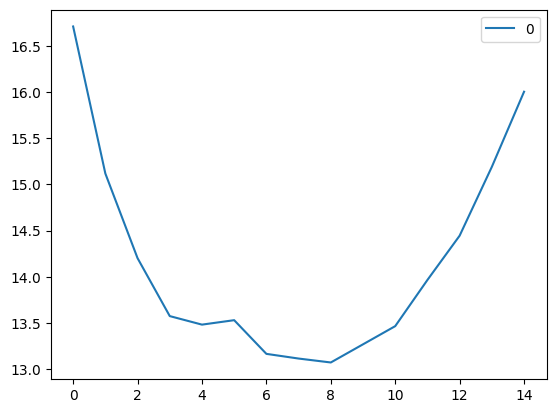

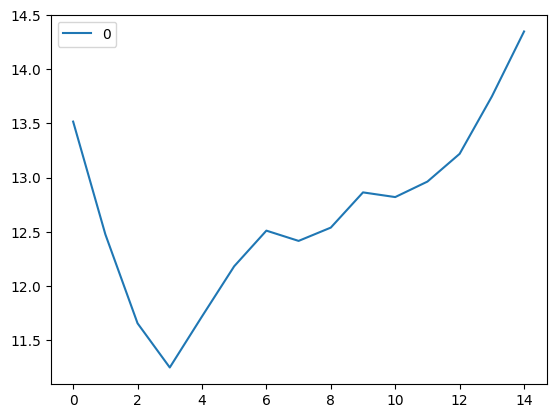

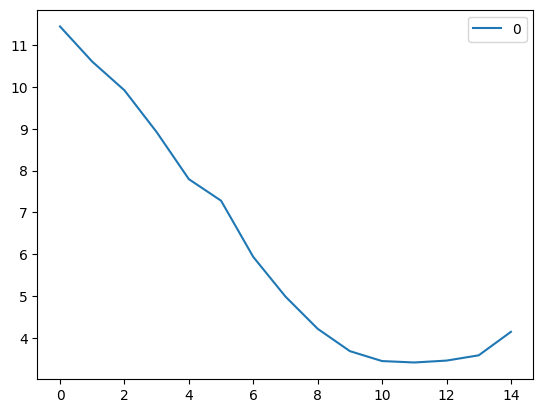

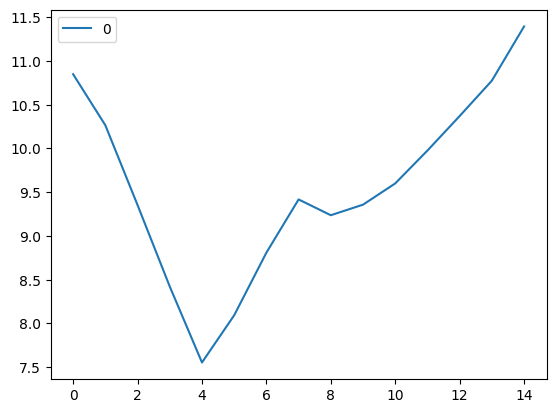

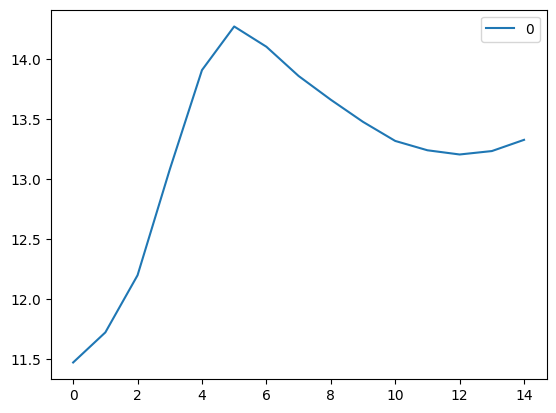

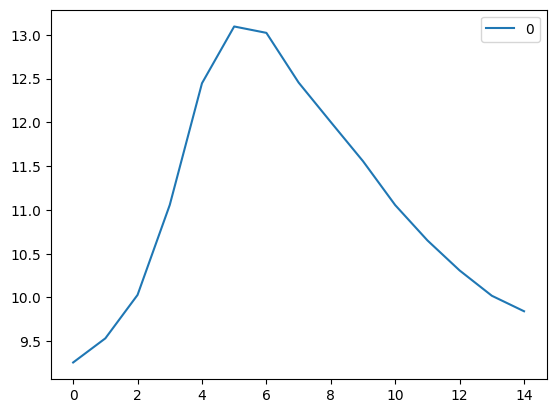

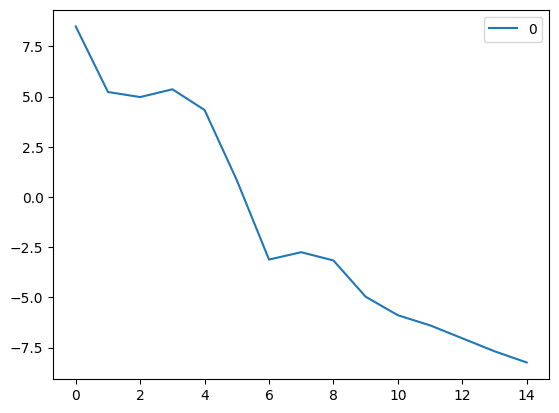

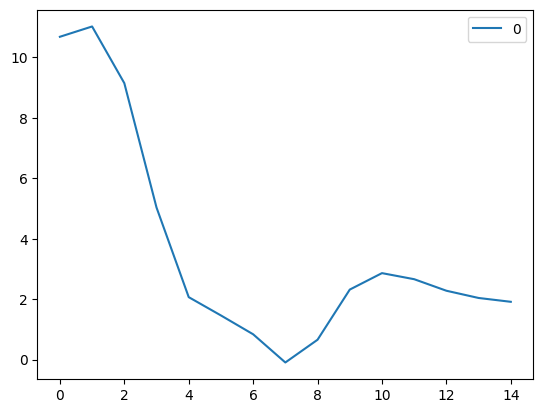

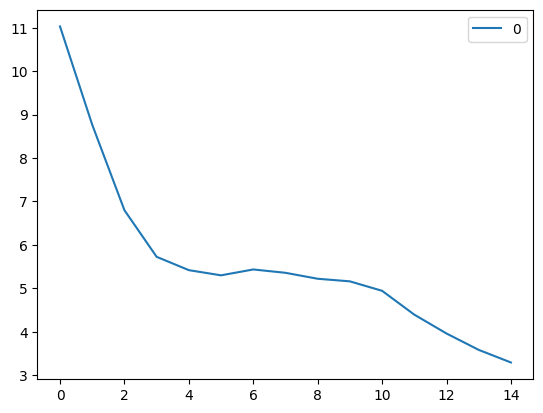

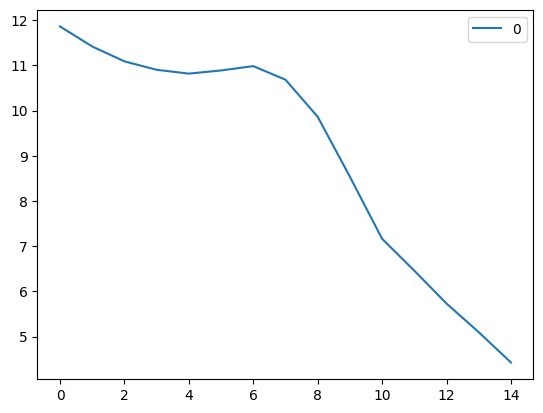

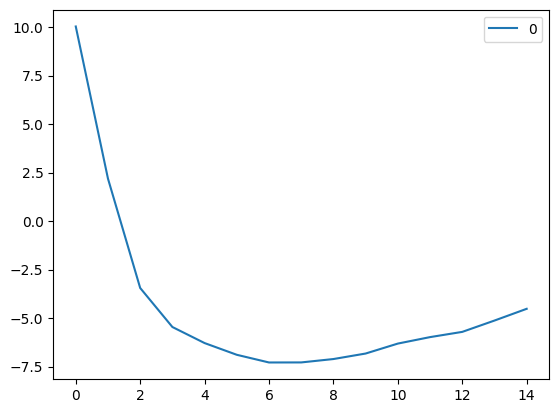

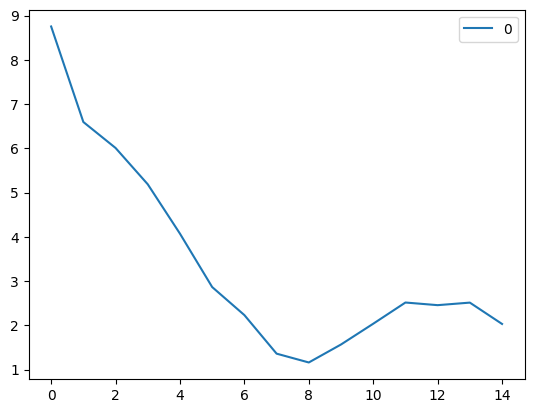

In [45]:
for prev in previsoes:
    prev.plot()

In [23]:
ativo_df_prev = preparar_dados_financeiros("PETR3.SA",1,start="2010-01-01",end="2023-07-08",remove_out=False)

tsi_df_prev= GetTsi(ativo_df_prev, 80, 0.002)


fig = go.Figure()

fig.add_trace(go.Scatter(x=tsi_df_prev.index, y=tsi_df_prev["tsi"]))
fig.add_trace(go.Scatter(x=tsi_df_prev.index, y=tsi_df_prev["gaussian"]))

fig.show()

PETR3.SA
[*********************100%***********************]  1 of 1 completed


In [11]:
fig = go.Figure(data=[go.Candlestick(x=ativo_df_prev.index,
                open=ativo_df_prev['Open'],
                high=ativo_df_prev['High'],
                low=ativo_df_prev['Low'],
                close=ativo_df_prev['Close'])])

fig.show()